# Lab Six: Convolutional Neural Networks
##### Sian Xiao & Tingting Zhao

* select a prediction task to perform on your dataset
* evaluate a deep learning architecture
* tune hyper-parameters.

## 0. Dataset Selection

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.
The Chinese MNIST (Chinese numbers handwritten characters images) dataset is downloaded from Kaggle. It's collected and modified from a project at Newcastle University.

The Chinese MNIST (Chinese numbers handwritten characters images) dataset is downloaded from [Kaggle](https://www.kaggle.com/gpreda/chinese-mnist). It's collected and modified from a [project at Newcastle University](https://data.ncl.ac.uk/articles/dataset/Handwritten_Chinese_Numbers/10280831/1).

In the original project, one hundred Chinese nationals took part in data collection. Each participant wrote with a standard black ink pen all 15 numbers in a table with 15 designated regions drawn on a white A4 paper. This process was repeated 10 times with each participant. Each sheet was scanned at the resolution of 300x300 pixels.
It resulted a dataset of 15000 images, each representing one character from a set of 15 characters (grouped in samples, grouped in suites, with 10 samples/volunteer and 100 volunteers).

The modified dataset (Kaggle) contains the following:
* an index file, chinese_mnist.csv
* a folder with 15,000 jpg images, sized 64 x 64.

The .csv file contains a data frame with following attributes:
* `suite_id`: There are totally 100 suites, each created by a volunteer.
* `sample_id`: Each volunteer created 10 samples.
* `code`: Each sample contains characters from 0 to 100M (totally 15 Chinese number characters). This is a code used to identify.
* `value`: Numerical value of each character.
* `character`:The actual Chinese character corresponding to one number.

The mapping of value, character and code is shown below:

| value     | character | code |
|-----------|-----------|------|
| 0         | 零        | 1    |
| 1         | 一        | 2    |
| 2         | 二        | 3    |
| 3         | 三        | 4    |
| 4         | 四        | 5    |
| 5         | 五        | 6    |
| 6         | 六        | 7    |
| 7         | 七        | 8    |
| 8         | 八        | 9    |
| 9         | 九        | 10   |
| 10        | 十        | 11   |
| 100       | 百        | 12   |
| 1000      | 千        | 13   |
| 10000     | 万        | 14   |
| 100000000 | 亿        | 15   |

The file names are `<suite_id>_<sample_id>_<code>.jpg`.

In [1]:
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import os
import numpy as np
from collections import Counter
import cv2
from PIL import Image,ImageOps  # trying to use tf gpu, however the tf-gpu on M2 does not has cv2, it has PIL. you can change it back

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil
from tensorflow.keras.layers import Add, Input, average, concatenate, Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.models import Sequential, Model

%matplotlib inline

## 1. Preparation (3 points total)  
### 1.1 Metrics
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

In [3]:
data = pd.read_csv('data/chinese_mnist.csv', encoding='utf-8')
data_group = data.groupby(by=['code','value'])
data_group.character.value_counts()

code  value      character
1     0          零            1000
2     1          一            1000
3     2          二            1000
4     3          三            1000
5     4          四            1000
6     5          五            1000
7     6          六            1000
8     7          七            1000
9     8          八            1000
10    9          九            1000
11    10         十            1000
12    100        百            1000
13    1000       千            1000
14    10000      万            1000
15    100000000  亿            1000
Name: character, dtype: int64

In [4]:
image_files = list(os.listdir("data/image"))
print(f"Number of image files in folder: {len(image_files)}")
print(f"Number of instances in csv: {len(data)}")

Number of image files in folder: 15000
Number of instances in csv: 15000


**As the dataset itself is well-organized to be balanced, and we care each category equaily, we don't need to use those complicated metrics designed for unbalanced dataset (like Cohen’s Kappa),precision, recall, F1 score. We can use accuracy (ACC), and Matthews correlation coefficient (MCC),Hamming loss. Confusion matrix can be used to visualize the result. Hamming loss here is just the same as ACC, and MCC is more designed for binary classification. So here we just use accuracy as evaluation metrics**

In [5]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
from sklearn.metrics import multilabel_confusion_matrix, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

### 1.2 Splits


In [6]:
%%time

# from concurrent.futures import ThreadPoolExecutor as tpe
# with tpe() as pool:
#     X_list, y_list = zip([i,pool.map load_files

X_list, y_list = [], []
for file in image_files:
    code = int(file.split('.jpg')[0].split('_')[-1])
    img_path = 'data/image/' + file
   # img=ImageOps.grayscale(Image.open(img_path))
    #img_re=np.array(ImageOps.invert(img))
    img = cv2.imread(img_path, 0)  # Load image in grayscale mode
    img_re = cv2.bitwise_not(img)
    img_new = img_re/255.0 -0.5  # Zero mean
    X_list.append(img_new)
    y_list.append(code-1)  # Zero base to use keras.utils.to_categorical

X_ori = np.array(X_list)
y_ori = np.array(y_list)
### !!!Note!!!
### From here, code-1 is the index for value now!!!

CPU times: user 1.65 s, sys: 5.44 s, total: 7.09 s
Wall time: 13.4 s


| value     | 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 100 | 1E3 | 1E4 | 1E8 |
|-----------|----|----|----|----|----|----|----|----|----|----|----|-----|-----|-----|-----|
| code      | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12  | 13  | 14  | 15  |
| character | 零 | 一 | 二 | 三 | 四 | 五 | 六 | 七 | 八 | 九 | 十 | 百  | 千  | 万  | 亿  |
| y         | 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11  | 12  | 13  | 14  |

In [7]:
NUM_CLASSES = 15
img_wh = 64
X = np.expand_dims(X_ori.reshape((-1,img_wh,img_wh)), axis=3)
print(X[0].shape)
y = keras.utils.to_categorical(y_ori, NUM_CLASSES)
print(y[:10])

(64, 64, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


**We choose to use Stratified K-Folds cross-validator because it can preserve the percentage of samples for each class. As we hope to classify different characters, we should learn from each classification equally.**

In [8]:
skf = StratifiedKFold(n_splits=4)
train_idx_list, test_idx_list = [], []
# have to use y_ori ('multiclass') to use StratifiedKFold
# but index is universal for y and y_ori
for train_idx, test_idx in skf.split(X, y_ori):
    train_idx_list.append(train_idx)
    test_idx_list.append(test_idx)

In [9]:
for i in range(4):
    fold = list(y_ori[train_idx_list[0]])
    print(Counter(fold))

Counter({11: 750, 14: 750, 7: 750, 0: 750, 13: 750, 5: 750, 6: 750, 12: 750, 8: 750, 4: 750, 10: 750, 3: 750, 2: 750, 1: 750, 9: 750})
Counter({11: 750, 14: 750, 7: 750, 0: 750, 13: 750, 5: 750, 6: 750, 12: 750, 8: 750, 4: 750, 10: 750, 3: 750, 2: 750, 1: 750, 9: 750})
Counter({11: 750, 14: 750, 7: 750, 0: 750, 13: 750, 5: 750, 6: 750, 12: 750, 8: 750, 4: 750, 10: 750, 3: 750, 2: 750, 1: 750, 9: 750})
Counter({11: 750, 14: 750, 7: 750, 0: 750, 13: 750, 5: 750, 6: 750, 12: 750, 8: 750, 4: 750, 10: 750, 3: 750, 2: 750, 1: 750, 9: 750})


**It's perfectly balanced.**

## 2. Modeling

### 2.1 Data expansion

**Since in real example the character may be captured  in different direaction, distorted, so we turn on rotation, width_shift, height_shift,zoom functions. Because flipping a character will not confuse the character with another, so flipping is meaningless in this case.**

**Let's use the first fold as example.**

In [10]:
X_train, X_test = X[train_idx_list[0]], X[test_idx_list[0]]
y_train, y_test = y[train_idx_list[0]], y[test_idx_list[0]] # note here we have to use one hot encoded y.

In [11]:
%%time

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5,  # people would write characters slightly different in direction
    width_shift_range=4,  # same as 0.046875, allow move within 4 pixels.
    height_shift_range=4,  # same as 0.046875, allow move within 4 pixels.
    shear_range=0.,  # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.03,  # different people write characters of different sizes
    channel_shift_range=0.,
    fill_mode='nearest',  # I think it's the same to use 'constant' since edges of picture are 1.0
    cval=1.,
    horizontal_flip=False,  # flip a character is meaningless in our case
    vertical_flip=False,  # flip a character is meaningless in our case
    rescale=None)

datagen.fit(X_train)

CPU times: user 77.5 ms, sys: 84.3 ms, total: 162 ms
Wall time: 161 ms


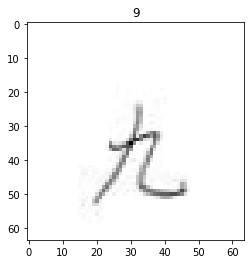

In [12]:
tmps = datagen.flow(X_train, y_train, batch_size=1)
labels = ["零","一","二","三","四","五","六","七","八","九","十","百","千","万","亿"]
for tmp in tmps:
    plt.imshow(tmp[0].squeeze(), cmap=plt.cm.gray)
    plt.title(np.argmax(tmp[1]))  # didn't install Chinese font in my matplotlib, can't use labels[].
    break

### 2.2 CNN architectures
**Here we used AlexNet (Alex), ResNet and Ensemble Nets (EnsNet) three architectures, each architecture we enhanced the number of filter by 8 times and add one more layer of the fully connected MLP.**

#### 2.2.1 AlexNet_1

In [13]:
### AlexNet style convolutional phase ###

Alex_1 = Sequential(name='Alex_1')

Alex_1.add(Conv2D(filters=8, input_shape = (img_wh,img_wh,1),kernel_size=(3,3), 
                  padding='same', activation='relu', data_format="channels_last"))
Alex_1.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
Alex_1.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))


Alex_1.add(Dropout(0.25))
Alex_1.add(Flatten())
Alex_1.add(Dense(128, activation='relu'))
Alex_1.add(Dropout(0.5))
Alex_1.add(Dense(NUM_CLASSES, activation='softmax'))

Alex_1.compile(loss='categorical_crossentropy',  # 'categorical_crossentropy' 'mean_squared_error'
               optimizer='rmsprop',  # 'adadelta' 'rmsprop'
               metrics=['accuracy']
              )
Alex_1.summary()

Model: "Alex_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0    

In [14]:
%%time
# the flow method yields batches of images indefinitely, with the given transformations
history_Alex_1 = Alex_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                      steps_per_epoch=int(len(X_train)/64),
                                      epochs=30, verbose=1,
                                      validation_data=(X_test,y_test),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                     )

Epoch 1/30


/users/zhaot/software/anaconda3/envs/mlenv2021/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1839: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


175/175 [==============================] - 8s 45ms/step - loss: 2.8478 - accuracy: 0.0869 - val_loss: 2.2628 - val_accuracy: 0.3491
Epoch 2/30
175/175 [==============================] - 7s 38ms/step - loss: 2.2692 - accuracy: 0.2672 - val_loss: 1.7219 - val_accuracy: 0.5152
Epoch 3/30
175/175 [==============================] - 7s 38ms/step - loss: 1.9038 - accuracy: 0.3834 - val_loss: 1.2491 - val_accuracy: 0.6584
Epoch 4/30
175/175 [==============================] - 7s 38ms/step - loss: 1.5103 - accuracy: 0.5096 - val_loss: 0.8812 - val_accuracy: 0.7525
Epoch 5/30
175/175 [==============================] - 7s 38ms/step - loss: 1.2623 - accuracy: 0.5781 - val_loss: 0.7397 - val_accuracy: 0.7872
Epoch 6/30
175/175 [==============================] - 7s 38ms/step - loss: 1.1459 - accuracy: 0.6117 - val_loss: 0.6545 - val_accuracy: 0.8019
Epoch 7/30
175/175 [==============================] - 7s 38ms/step - loss: 1.0603 - accuracy: 0.6465 - val_loss: 0.5691 - val_accuracy: 0.8328
Epoch 8/30

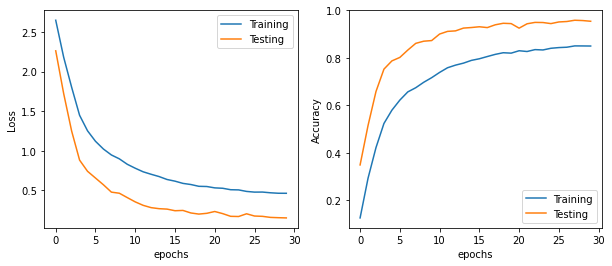

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_Alex_1.history['loss'],label='Training')
plt.plot(history_Alex_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_Alex_1.history['accuracy'],label='Training')
plt.plot(history_Alex_1.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

**Alex_2**

In [16]:
### AlexNet style convolutional phase ###

Alex_2 = Sequential(name='Alex_2')

Alex_2.add(Conv2D(filters=64, input_shape = (img_wh,img_wh,1),kernel_size=(3,3), 
                  padding='same', activation='relu', data_format="channels_last"))
Alex_2.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
Alex_2.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))
    

# add one layer on flattened output
Alex_2.add(Dropout(0.20))
Alex_2.add(Flatten())
Alex_2.add(Dense(128, activation='relu'))
Alex_2.add(Dropout(0.40))
Alex_2.add(Dense(64, activation='relu'))
Alex_2.add(Dropout(0.60))
Alex_2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
Alex_2.compile(loss='categorical_crossentropy',
               optimizer='rmsprop',
               metrics=['accuracy']
               )
Alex_2.summary()

Model: "Alex_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0    

In [17]:
%%time

history_Alex_2 = Alex_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                      steps_per_epoch=int(len(X_train)/64),
                                      epochs=30, verbose=1,
                                      validation_data=(X_test,y_test),
                                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                     )

Epoch 1/30
175/175 [==============================] - 54s 303ms/step - loss: 3.1762 - accuracy: 0.0826 - val_loss: 1.9328 - val_accuracy: 0.4493
Epoch 2/30
175/175 [==============================] - 52s 299ms/step - loss: 2.0983 - accuracy: 0.3026 - val_loss: 1.0496 - val_accuracy: 0.7120
Epoch 3/30
175/175 [==============================] - 52s 296ms/step - loss: 1.5269 - accuracy: 0.4755 - val_loss: 0.7290 - val_accuracy: 0.7725
Epoch 4/30
175/175 [==============================] - 52s 297ms/step - loss: 1.2039 - accuracy: 0.5868 - val_loss: 0.5145 - val_accuracy: 0.8469
Epoch 5/30
175/175 [==============================] - 52s 296ms/step - loss: 1.0398 - accuracy: 0.6439 - val_loss: 0.4258 - val_accuracy: 0.8661
Epoch 6/30
175/175 [==============================] - 52s 296ms/step - loss: 0.9039 - accuracy: 0.6866 - val_loss: 0.3696 - val_accuracy: 0.8821
Epoch 7/30
175/175 [==============================] - 52s 299ms/step - loss: 0.8305 - accuracy: 0.7153 - val_loss: 0.3021 - val_ac

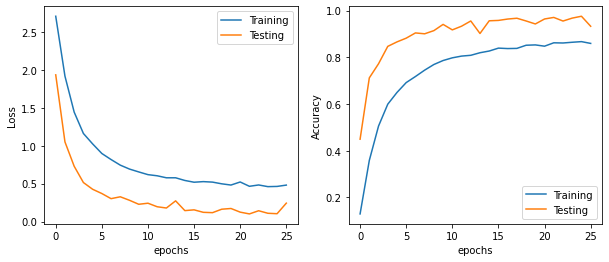

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_Alex_2.history['loss'],label='Training')
plt.plot(history_Alex_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_Alex_2.history['accuracy'],label='Training')
plt.plot(history_Alex_2.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.2 ResNet_1

In [19]:
### ResNet-Style Bypass ###
l2_lambda= 0.000001
input_holder = Input(shape=(img_wh, img_wh, 1))

x = Conv2D(filters=8, input_shape = (img_wh,img_wh,1), kernel_size=(3,3),
           kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda),
           padding='same', activation='relu', data_format="channels_last")(input_holder)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)
x = Conv2D(filters=8, kernel_size=(3,3), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Conv2D(filters=16, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same', activation='relu', 
           data_format="channels_last")(x_split)
x = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)
x = Conv2D(filters=8, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)


x = Add()([x, x_split])
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

ResNet_1 = Model(inputs=input_holder, outputs=x, name='ResNet_1')
ResNet_1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
ResNet_1.summary()

Model: "ResNet_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 8)    584         max_pooling2d_2[0][0]            
___________________________________________________________________________________________

In [20]:
%%time

# the flow method yields batches of images indefinitely, with the given transofmrations
history_ResNet_1 = ResNet_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 8s 39ms/step - loss: 2.6994 - accuracy: 0.1213 - val_loss: 1.7355 - val_accuracy: 0.4832
Epoch 2/30
175/175 [==============================] - 6s 36ms/step - loss: 1.8804 - accuracy: 0.3864 - val_loss: 0.9355 - val_accuracy: 0.7216
Epoch 3/30
175/175 [==============================] - 6s 36ms/step - loss: 1.3126 - accuracy: 0.5595 - val_loss: 0.6532 - val_accuracy: 0.7936
Epoch 4/30
175/175 [==============================] - 6s 36ms/step - loss: 0.9964 - accuracy: 0.6544 - val_loss: 0.4635 - val_accuracy: 0.8544
Epoch 5/30
175/175 [==============================] - 6s 36ms/step - loss: 0.8300 - accuracy: 0.7138 - val_loss: 0.3436 - val_accuracy: 0.8997
Epoch 6/30
175/175 [==============================] - 6s 36ms/step - loss: 0.7169 - accuracy: 0.7587 - val_loss: 0.2827 - val_accuracy: 0.9203
Epoch 7/30
175/175 [==============================] - 6s 36ms/step - loss: 0.6218 - accuracy: 0.7856 - val_loss: 0.2373 - val_accuracy: 0.9264

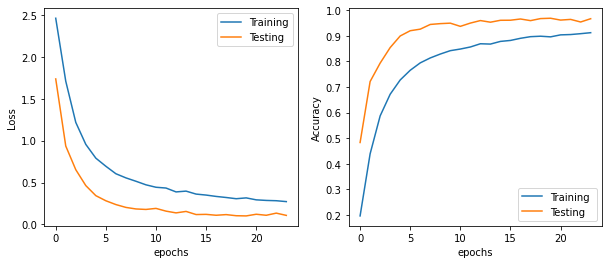

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_1.history['loss'],label='Training')
plt.plot(history_ResNet_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_1.history['accuracy'],label='Training ')
plt.plot(history_ResNet_1.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

**ResNet_2**

In [22]:
%%time

input_holder = Input(shape=(img_wh, img_wh, 1))

x = Conv2D(filters=64, input_shape = (img_wh,img_wh,1), kernel_size=(3,3),
           kernel_initializer='he_uniform', kernel_regularizer=l2(l2_lambda),
           padding='same', activation='relu', data_format="channels_last")(input_holder)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)
x = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_uniform', 
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Conv2D(filters=128, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same', activation='relu', 
           data_format="channels_last")(x_split)
x = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)
x = Conv2D(filters=64, kernel_size=(1,1), kernel_initializer='he_uniform',
           kernel_regularizer=l2(l2_lambda), padding='same',
           activation='relu', data_format="channels_last")(x)


x = Add()([x, x_split])
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2,2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.20)(x)
x = Flatten()(x)
x = Dense(512)(x)
x = Activation("relu")(x)
x  = Dropout(0.40)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x  = Dropout(0.60)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)


ResNet_2 = Model(inputs=input_holder, outputs=x, name='ResNet_2')
ResNet_2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
ResNet_2.summary()

Model: "ResNet_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 64)   36928       max_pooling2d_5[0][0]            
___________________________________________________________________________________________

In [23]:
%%time

# the flow method yields batches of images indefinitely, with the given transofmrations
history_ResNet_2 = ResNet_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1,
                                          validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 15s 78ms/step - loss: 2.6451 - accuracy: 0.1662 - val_loss: 0.9341 - val_accuracy: 0.6888
Epoch 2/30
175/175 [==============================] - 13s 76ms/step - loss: 0.9455 - accuracy: 0.6757 - val_loss: 0.3355 - val_accuracy: 0.8840
Epoch 3/30
175/175 [==============================] - 13s 76ms/step - loss: 0.5070 - accuracy: 0.8324 - val_loss: 0.1177 - val_accuracy: 0.9608
Epoch 4/30
175/175 [==============================] - 13s 76ms/step - loss: 0.3222 - accuracy: 0.8954 - val_loss: 0.0736 - val_accuracy: 0.9763
Epoch 5/30
175/175 [==============================] - 13s 74ms/step - loss: 0.2298 - accuracy: 0.9279 - val_loss: 0.0631 - val_accuracy: 0.9795
Epoch 6/30
175/175 [==============================] - 13s 76ms/step - loss: 0.1781 - accuracy: 0.9457 - val_loss: 0.1233 - val_accuracy: 0.9587
Epoch 7/30
175/175 [==============================] - 13s 75ms/step - loss: 0.1823 - accuracy: 0.9456 - val_loss: 0.1028 - val_accuracy:

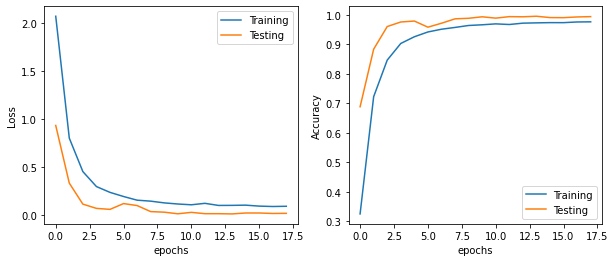

In [24]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_2.history['loss'],label='Training')
plt.plot(history_ResNet_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_2.history['accuracy'],label='Training')
plt.plot(history_ResNet_2.history['val_accuracy'],label='Testing')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

#### 2.2.3 EnsNet_1

In [25]:
### Ensemble Nets ###

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=16,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=16,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=16,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=16,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.25)(x) # add some dropout for regularization after conv layers
    x = Dense(32, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

EnsNet_1 = Model(inputs=input_holder, outputs=x, name='EnsNet_1')
EnsNet_1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
EnsNet_1.summary()

Model: "EnsNet_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 16)   2320        conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_15[0][0]                  
___________________________________________________________________________________________

In [26]:
%%time

history_EnsNet_1 = EnsNet_1.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1, validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 10s 47ms/step - loss: 2.4464 - accuracy: 0.2105 - val_loss: 0.7813 - val_accuracy: 0.7264
Epoch 2/30
175/175 [==============================] - 8s 45ms/step - loss: 0.6926 - accuracy: 0.7657 - val_loss: 0.3902 - val_accuracy: 0.8613
Epoch 3/30
175/175 [==============================] - 8s 46ms/step - loss: 0.3661 - accuracy: 0.8760 - val_loss: 0.2534 - val_accuracy: 0.9117
Epoch 4/30
175/175 [==============================] - 8s 45ms/step - loss: 0.2523 - accuracy: 0.9184 - val_loss: 0.1382 - val_accuracy: 0.9520
Epoch 5/30
175/175 [==============================] - 8s 45ms/step - loss: 0.1780 - accuracy: 0.9414 - val_loss: 0.0800 - val_accuracy: 0.9755
Epoch 6/30
175/175 [==============================] - 8s 46ms/step - loss: 0.1659 - accuracy: 0.9455 - val_loss: 0.0868 - val_accuracy: 0.9667
Epoch 7/30
175/175 [==============================] - 8s 45ms/step - loss: 0.1345 - accuracy: 0.9560 - val_loss: 0.0730 - val_accuracy: 0.976

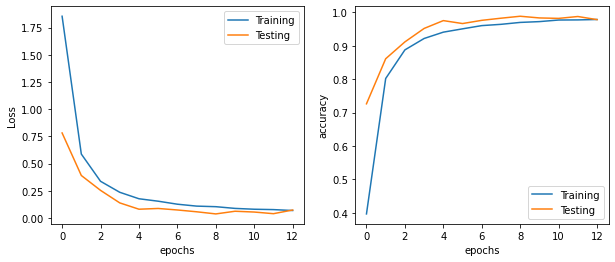

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_EnsNet_1.history['loss'],label='Training')
plt.plot(history_EnsNet_1.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_EnsNet_1.history['accuracy'],label='Training')
plt.plot(history_EnsNet_1.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

**EnsNet_2**

In [28]:
### Ensemble Nets ###

num_ensembles = 3
l2_lambda = 0.000001

input_holder = Input(shape=(img_wh, img_wh, 1))

# start with a conv layer
x = Conv2D(filters=64,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=128,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.25)(x) # add some dropout for regularization after conv layers
    x = Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64,
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    x = Dense(NUM_CLASSES, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(NUM_CLASSES, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

EnsNet_2 = Model(inputs=input_holder, outputs=x, name='EnsNet_2')
EnsNet_2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                 optimizer='rmsprop', # 'adadelta' 'rmsprop'
                 metrics=['accuracy']
                )
EnsNet_2.summary()

Model: "EnsNet_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 64, 64, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 32, 32, 64)   0           conv2d_29[0][0]                  
___________________________________________________________________________________________

In [29]:
%%time

history_EnsNet_2 = EnsNet_2.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                                          steps_per_epoch=int(len(X_train)/64),
                                          epochs=30, verbose=1, validation_data=(X_test,y_test),
                                          callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                         )

Epoch 1/30
175/175 [==============================] - 54s 294ms/step - loss: 4.3189 - accuracy: 0.1311 - val_loss: 0.7146 - val_accuracy: 0.7805
Epoch 2/30
175/175 [==============================] - 50s 288ms/step - loss: 1.1872 - accuracy: 0.6403 - val_loss: 0.3279 - val_accuracy: 0.8888
Epoch 3/30
175/175 [==============================] - 50s 287ms/step - loss: 0.5950 - accuracy: 0.8114 - val_loss: 0.1628 - val_accuracy: 0.9499
Epoch 4/30
175/175 [==============================] - 50s 288ms/step - loss: 0.3697 - accuracy: 0.8852 - val_loss: 0.1059 - val_accuracy: 0.9648
Epoch 5/30
175/175 [==============================] - 50s 288ms/step - loss: 0.3115 - accuracy: 0.9057 - val_loss: 0.0753 - val_accuracy: 0.9792
Epoch 6/30
175/175 [==============================] - 50s 288ms/step - loss: 0.2160 - accuracy: 0.9366 - val_loss: 0.0655 - val_accuracy: 0.9771
Epoch 7/30
175/175 [==============================] - 50s 288ms/step - loss: 0.1721 - accuracy: 0.9516 - val_loss: 0.0506 - val_ac

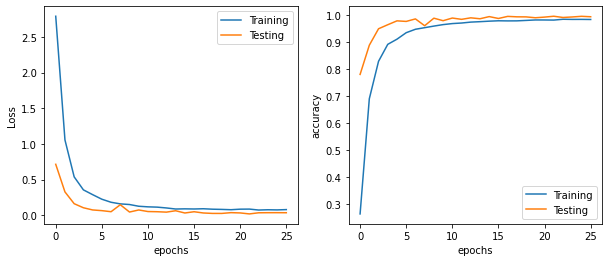

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_EnsNet_2.history['loss'],label='Training')
plt.plot(history_EnsNet_2.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_EnsNet_2.history['accuracy'],label='Training')
plt.plot(history_EnsNet_2.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

### 2.3 Visualization and Comparison
*Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.*
### 2.3.1 Visualization

In [31]:
# visualize

def visualize_models(X_test, y_test, model_names=[], labels='auto'):
    
    assert isinstance(model_names, list)
    assert all(isinstance(name, str) for name in model_names)
    assert isinstance(y_test[0], np.int64)
    
    height = ceil(len(model_names)/2)
    
    plt.figure(figsize=(20,6*height))
    
    for i, name in enumerate(model_names):
        model = eval(name)
        yhat_model = np.argmax(model.predict(X_test), axis=1)
        acc_model = mt.accuracy_score(y_test,yhat_model)
        plt.subplot(height,2,i+1)
        cm = mt.confusion_matrix(y_test,yhat_model)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels,
                    cmap = sns.color_palette("YlOrBr", as_cmap=True))
        plt.title(f'{str(name)}: {acc_model}', fontsize=20)
    plt.tight_layout()

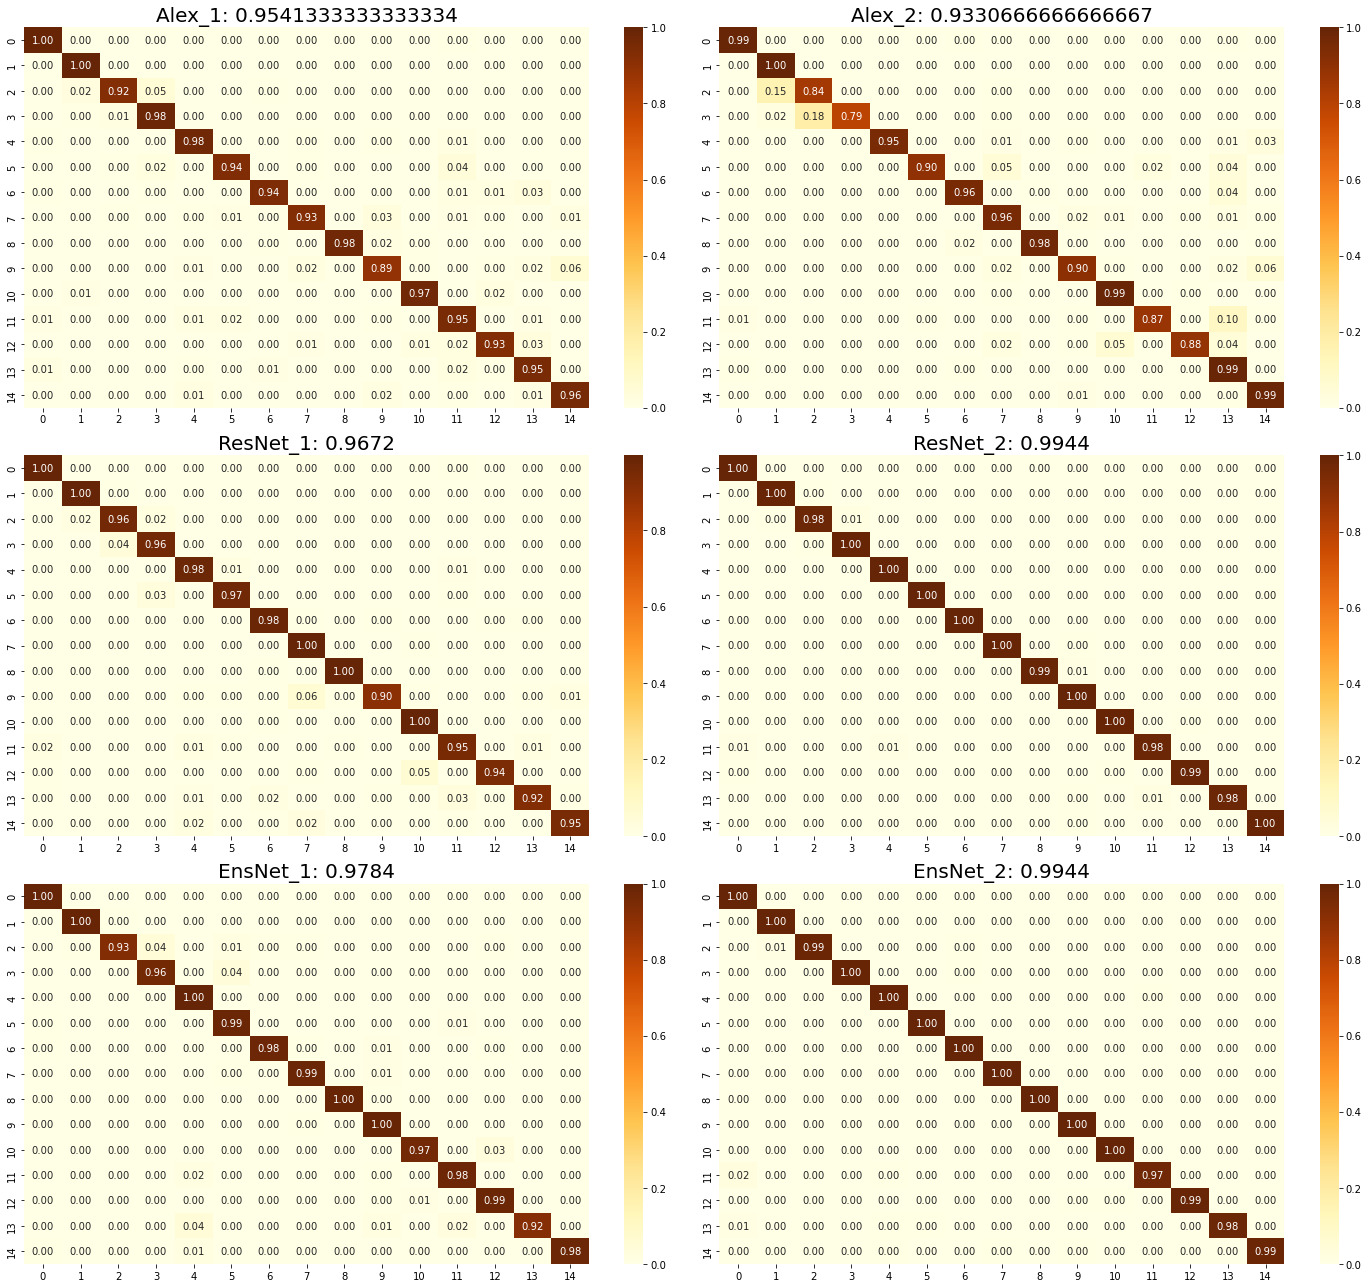

In [32]:
# have to use y_ori since it's 
visualize_models(X_test, y_ori[test_idx_list[0]], labels='auto',
                 model_names=['Alex_1', 'Alex_2', 'ResNet_1', 'ResNet_2', 'EnsNet_1', 'EnsNet_2'])

**As we can see, it seems EnsNet is better than ResNet, Alex got relatively the worsest results. Let's use statistical method to do the comparison.**

### 2.3.2 Comparison

In [33]:
# Define a function for McNemar's Test
# confidence:           0.90  0.95  0.99
# 1DOF critical value: 2.706 3.841 6.635

def mn_test(ypred1, ypred2, ytrue):
    tab_b = sum((ypred1 == ytrue) & (ypred2 != ytrue))
    tab_c = sum((ypred1 != ytrue) & (ypred2 == ytrue))

    if tab_b + tab_c == 0:
        chi2 = 0
    else:
        chi2 = (abs(tab_b - tab_c)-1)**2 / (tab_b + tab_c)
    
    return round(chi2,4)

**we would like to compare between same architecture with different parameters.**

In [34]:
yhat_Alex_1 = np.argmax(Alex_1.predict(X_test), axis=1)
yhat_Alex_2 = np.argmax(Alex_2.predict(X_test), axis=1)
yhat_ResNet_1 = np.argmax(ResNet_1.predict(X_test), axis=1)
yhat_ResNet_2 = np.argmax(ResNet_2.predict(X_test), axis=1)
yhat_EnsNet_1 = np.argmax(EnsNet_1.predict(X_test), axis=1)
yhat_EnsNet_2 = np.argmax(EnsNet_2.predict(X_test), axis=1)

In [35]:
print("Alex 1 vs Alex 2: Test statistic",mn_test(yhat_Alex_1, yhat_Alex_2, y_ori[test_idx_list[0]]))
print("ResNet 1 vs ResNet 2: Test statistic",mn_test(yhat_ResNet_1, yhat_ResNet_2, y_ori[test_idx_list[0]]))
print("EnsNet 1 vs EnsNet 2: Test statistic",mn_test(yhat_EnsNet_1, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

Alex 1 vs Alex 2: Test statistic 23.8588
ResNet 1 vs ResNet 2: Test statistic 80.9603
EnsNet 1 vs EnsNet 2: Test statistic 40.4767


**As we can see, `EnsNet_2`,`ResNet_2` and `Alex_2` are different from `EnsNet_1`,`ResNet_1` and `Alex_1`, respectively. While these `EnsNet_2`, `ResNet_2` and `Alex_1` have higher accuracy, we would say they have better perfromance.**


**Let's compare `Alex_1` , `ResNet_2` and `EnsNet_2`.**

In [36]:
print("ResNet 2 vs EnsNet 2: Test statistic",mn_test(yhat_ResNet_2, yhat_EnsNet_2, y_ori[test_idx_list[0]]))
print("Alex 1 vs EnsNet 2: Test statistic",mn_test(yhat_Alex_1, yhat_EnsNet_2, y_ori[test_idx_list[0]]))
print("Alex 1 vs ResNet 2: Test statistic",mn_test(yhat_Alex_1, yhat_ResNet_2, y_ori[test_idx_list[0]]))

ResNet 2 vs EnsNet 2: Test statistic 0.0278
Alex 1 vs EnsNet 2: Test statistic 131.5789
Alex 1 vs ResNet 2: Test statistic 125.6983


**$\chi^2$ value for Alex 1 vs EnsNet 2 and Alex 1 vs ResNet 2 are larger than 6.635, so we can say they are different by 99% confidence, and Alex_1 is worse, however $\chi^2$ value for ResNet 2 vs EnsNet 2 is smaller than 2.706, we even can not conclude EnsNet is better than ResNet with 90% confidence.**

### 2.4 CNN vs. MLP


**Let's first implement a MLP. Here we tried to use raw data, PCA reduced data, Daisy extraction data to build MLP model.**

In [37]:
#raw data
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=X_train.shape[1], units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )
mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])
history_MLP = mlp.fit(X_train, y_train, batch_size=32,
                       epochs=50, verbose=1, validation_data=(X_test,y_test),
                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                      )

Epoch 1/50
352/352 [==============================] - 1s 3ms/step - loss: 0.0629 - accuracy: 0.0631 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 2/50
352/352 [==============================] - 1s 2ms/step - loss: 0.0622 - accuracy: 0.0698 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 3/50
352/352 [==============================] - 1s 2ms/step - loss: 0.0622 - accuracy: 0.0579 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 4/50
352/352 [==============================] - 1s 2ms/step - loss: 0.0622 - accuracy: 0.0636 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 5/50
352/352 [==============================] - 1s 2ms/step - loss: 0.0622 - accuracy: 0.0631 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 6/50
352/352 [==============================] - 1s 2ms/step - loss: 0.0622 - accuracy: 0.0703 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 7/50
352/352 [==============================] - 1s 2ms/step - loss: 0.0622 - accuracy: 0.0668 - val_loss: 0.0622 - val_accuracy: 0.0667
Epoch 

**Using raw data as input, the accuracy is terriable**

In [39]:
#PCA

from sklearn.decomposition import PCA
n_components = 750
pca= PCA(n_components=n_components).fit(X_train.reshape(X_train.shape[0],-1))
X_train_pca =pca.transform(X_train.reshape(X_train.shape[0],-1))
X_test_pca =pca.transform(X_test.reshape(X_test.shape[0],-1))

In [40]:
mlp_pca = Sequential()
mlp_pca.add( Flatten() ) # make images flat for the MLP input
mlp_pca.add( Dense(input_dim=X_train_pca.shape[1], units=30, 
               activation='relu') )
mlp_pca.add( Dense(units=15, activation='relu') )
mlp_pca.add( Dense(NUM_CLASSES) )
mlp_pca.add( Activation('softmax') )
mlp_pca.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])
history_MLP_pca = mlp_pca.fit(X_train_pca, y_train, batch_size=32,
                       epochs=150, verbose=1, validation_data=(X_test_pca,y_test),
                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                      )

Epoch 1/150
352/352 [==============================] - 1s 2ms/step - loss: 0.0618 - accuracy: 0.1130 - val_loss: 0.0584 - val_accuracy: 0.2432
Epoch 2/150
352/352 [==============================] - 0s 1ms/step - loss: 0.0563 - accuracy: 0.2910 - val_loss: 0.0520 - val_accuracy: 0.3333
Epoch 3/150
352/352 [==============================] - 1s 1ms/step - loss: 0.0483 - accuracy: 0.3995 - val_loss: 0.0479 - val_accuracy: 0.4208
Epoch 4/150
352/352 [==============================] - 1s 1ms/step - loss: 0.0433 - accuracy: 0.4993 - val_loss: 0.0449 - val_accuracy: 0.4709
Epoch 5/150
352/352 [==============================] - 1s 1ms/step - loss: 0.0391 - accuracy: 0.5525 - val_loss: 0.0429 - val_accuracy: 0.5128
Epoch 6/150
352/352 [==============================] - 0s 1ms/step - loss: 0.0356 - accuracy: 0.6032 - val_loss: 0.0416 - val_accuracy: 0.5272
Epoch 7/150
352/352 [==============================] - 1s 1ms/step - loss: 0.0327 - accuracy: 0.6468 - val_loss: 0.0405 - val_accuracy: 0.5475

**From lab2, we knew using the first 750 of components is enough to represent the data, so here we used the first 750 components as input, and the accuracy was enhanced greatly. Let's try using Daisy**

In [41]:
#daisy
from skimage.feature import daisy
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=5, radius=5,
                 rings=2, histograms=8, orientations=8,
                 visualize=False)
    return feat.reshape((-1))
X_train_daisy = np.apply_along_axis(apply_daisy, 1, X_train.reshape(-1,64*64),(64,64))
print(X_train_daisy.shape)
X_test_daisy = np.apply_along_axis(apply_daisy, 1, X_test.reshape(-1,64*64),(64,64))
print(X_test_daisy.shape)

(11250, 16456)
(3750, 16456)


In [42]:
mlp_daisy = Sequential()
mlp_daisy.add( Flatten() ) # make images flat for the MLP input
mlp_daisy.add( Dense(input_dim=X_train_daisy.shape[1], units=30, 
               activation='relu') )
mlp_daisy.add( Dense(units=15, activation='relu') )
mlp_daisy.add( Dense(NUM_CLASSES) )
mlp_daisy.add( Activation('softmax') )

mlp_daisy.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

history_MLP_daisy= mlp_daisy.fit(X_train_daisy, y_train, batch_size=32,
                       epochs=150, verbose=1, validation_data=(X_test_daisy,y_test),
                       callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                      )

Epoch 1/150
352/352 [==============================] - 2s 4ms/step - loss: 0.0545 - accuracy: 0.3139 - val_loss: 0.0382 - val_accuracy: 0.5757
Epoch 2/150
352/352 [==============================] - 1s 3ms/step - loss: 0.0354 - accuracy: 0.6183 - val_loss: 0.0294 - val_accuracy: 0.6973
Epoch 3/150
352/352 [==============================] - 1s 3ms/step - loss: 0.0264 - accuracy: 0.7335 - val_loss: 0.0218 - val_accuracy: 0.7864
Epoch 4/150
352/352 [==============================] - 1s 3ms/step - loss: 0.0188 - accuracy: 0.8252 - val_loss: 0.0176 - val_accuracy: 0.8317
Epoch 5/150
352/352 [==============================] - 1s 3ms/step - loss: 0.0158 - accuracy: 0.8510 - val_loss: 0.0154 - val_accuracy: 0.8549
Epoch 6/150
352/352 [==============================] - 1s 2ms/step - loss: 0.0136 - accuracy: 0.8708 - val_loss: 0.0138 - val_accuracy: 0.8699
Epoch 7/150
352/352 [==============================] - 1s 3ms/step - loss: 0.0116 - accuracy: 0.8920 - val_loss: 0.0135 - val_accuracy: 0.8709

**Using Daisy, the accuracy was further enhanced!**

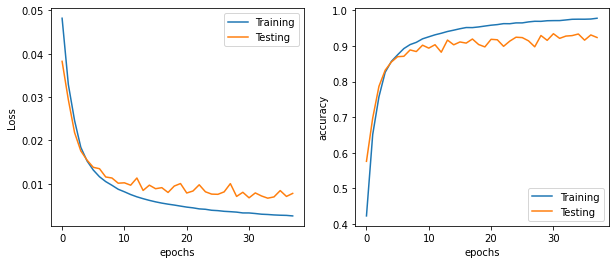

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_MLP_daisy.history['loss'],label='Training')
plt.plot(history_MLP_daisy.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_MLP_daisy.history['accuracy'],label='Training')
plt.plot(history_MLP_daisy.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

/users/zhaot/software/anaconda3/envs/mlenv2021/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


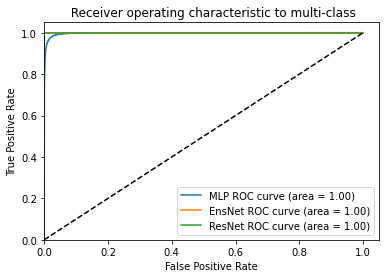

In [44]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
def roc(y_score):
    n_classes =15
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr,tpr,roc_auc

mlp_fpr,mlp_tpr,mlp_roc_auc=roc(mlp_daisy.predict_proba(X_test_daisy))
EnsNet_fpr,EnsNet_tpr,EnsNet_roc_auc=roc(EnsNet_2.predict(X_test))
ResNet_fpr,ResNet_tpr,ResNet_roc_auc=roc(ResNet_2.predict(X_test))
# Plot ROC curve
plt.figure()
plt.plot(mlp_fpr["micro"], mlp_tpr["micro"],
label='MLP ROC curve (area = {0:0.2f})'
               ''.format(mlp_roc_auc["micro"]))

plt.plot(EnsNet_fpr["micro"], EnsNet_tpr["micro"],
label='EnsNet ROC curve (area = {0:0.2f})'
               ''.format(EnsNet_roc_auc["micro"]))
plt.plot(ResNet_fpr["micro"], ResNet_tpr["micro"],
label='ResNet ROC curve (area = {0:0.2f})'
               ''.format(ResNet_roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**EnsNet and ResNet model are perfect, MLP model is almost perfect, it seems this data set is too easy.**

In [45]:
yhat_MLP = np.argmax(mlp_daisy.predict(X_test_daisy), axis=1)
print("MLP_DAISY  vs EnsNet_2: Test statistic",mn_test(yhat_MLP, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

MLP_DAISY  vs EnsNet_2: Test statistic 241.1626


**$\chi^2$ value for MLP_DAISY  vs EnsNet_2 is larger than 6.635, we can conclude that EnsNet is better than MLP with 99% confidence.**

## Excepional work (Transfer learning)

In [46]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [47]:
# only need to change X to 3 channels
# use the preprocessed y

X_list_tl = []
for file in image_files:
    code = int(file.split('.jpg')[0].split('_')[-1])
    img_path = 'data/image/' + file
    img = cv2.imread(img_path)
    X_list_tl.append(img)
    # ResNet requires: exactly 3 inputs channels, and width and height no smaller than 32.
    # valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)
    # didn't zero mean, because of the requirement of VGG19

X_tl = np.array(X_list_tl)
print(X_tl[0].shape)

(64, 64, 3)


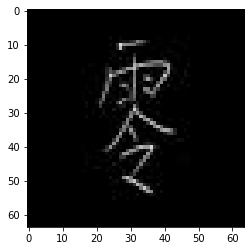

In [48]:
plt.imshow(X_tl[0])

In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

import tensorflow.keras.applications
# load only convolutional layers of resnet:
if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))

In [50]:
X_train_tl = X_tl[train_idx_list[0]]
X_test_tl = X_tl[test_idx_list[0]]

In [51]:
x_train_up = preprocess_input(X_train_tl)
x_test_up = preprocess_input(X_test_tl)

In [52]:
%%time

x_train_resnet = res_no_top.predict(x_train_up)
x_test_resnet = res_no_top.predict(x_test_up)
print(x_train_resnet.shape)

(11250, 2, 2, 2048)
CPU times: user 8min 19s, sys: 37.7 s, total: 8min 57s
Wall time: 25.7 s


In [53]:
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add, Flatten, Dense
from tensorflow.keras.layers import average, concatenate


# let's add a fully-connected layer
input_x = Input(shape=x_train_resnet[0].shape)
x = Flatten()(input_x)
x = Dense(2000, activation='relu',kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = Dense(200, activation='relu',kernel_initializer='he_uniform')(x)
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

ResNet_tl = Model(inputs=input_x, outputs=predictions, name='ResNet_tl')

ResNet_tl.summary()

Model: "ResNet_tl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2, 2, 2048)]      0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2000)              16386000  
_________________________________________________________________
dropout_19 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 200)               400200    
_________________________________________________________________
dense_38 (Dense)             (None, 15)                3015      
Total params: 16,789,215
Trainable params: 16,789,215
Non-trainable params: 0
_____________________________________________

In [54]:
ResNet_tl.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy']
                 )

In [55]:
%%time
history_ResNet_tl = ResNet_tl.fit(x_train_resnet, y_train, epochs=30, batch_size=64,
                                  verbose=1, validation_data=(x_test_resnet,y_test),
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                                 )

Epoch 1/30
176/176 [==============================] - 8s 43ms/step - loss: 4.3872 - accuracy: 0.5224 - val_loss: 0.5361 - val_accuracy: 0.8053
Epoch 2/30
176/176 [==============================] - 7s 42ms/step - loss: 0.5335 - accuracy: 0.8287 - val_loss: 0.2799 - val_accuracy: 0.9016
Epoch 3/30
176/176 [==============================] - 7s 42ms/step - loss: 0.3795 - accuracy: 0.8783 - val_loss: 0.2506 - val_accuracy: 0.9112
Epoch 4/30
176/176 [==============================] - 7s 42ms/step - loss: 0.3134 - accuracy: 0.8988 - val_loss: 0.2678 - val_accuracy: 0.9125
Epoch 5/30
176/176 [==============================] - 7s 41ms/step - loss: 0.3067 - accuracy: 0.9047 - val_loss: 0.2873 - val_accuracy: 0.9016
Epoch 6/30
176/176 [==============================] - 7s 42ms/step - loss: 0.2584 - accuracy: 0.9140 - val_loss: 0.1747 - val_accuracy: 0.9424
Epoch 7/30
176/176 [==============================] - 7s 42ms/step - loss: 0.2419 - accuracy: 0.9254 - val_loss: 0.2432 - val_accuracy: 0.9229

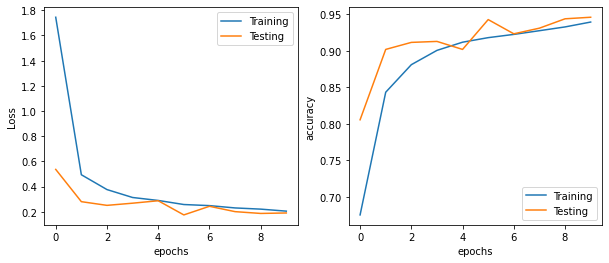

In [56]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_ResNet_tl.history['loss'],label='Training')
plt.plot(history_ResNet_tl.history['val_loss'],label='Testing')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_ResNet_tl.history['accuracy'],label='Training')
plt.plot(history_ResNet_tl.history['val_accuracy'],label='Testing')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

In [57]:
# compare ensnet_2 and resnet_tl
yhat_ResNet_tl = np.argmax(ResNet_tl.predict(x_test_resnet), axis=1)
print("ResNet_tl  vs EnsNet_2: Test statistic",mn_test(yhat_ResNet_tl, yhat_EnsNet_2, y_ori[test_idx_list[0]]))

ResNet_tl  vs EnsNet_2: Test statistic 160.0193


**$\chi^2$ value for ResNet_tl  vs EnsNet_2 is larger than 6.635, we can conclude that EnsNet is better than MLP with 99% confidence. Probably this data set is easy enough to predict.**